# LaRoSeDa Dataset

A Large and Romanian Sentiment Data Set. LaRoSeDa contains 15,000 reviews written in Romanian, of which 7,500 are positive and 7,500 negative. The samples have one of four star ratings: 1 or 2 - for reviews that can be considered of negative polarity, and 4 or 5 for the positive ones. The 15,000 samples featured in the corpus and labelled with the star rating, are splitted in a train and test subsets, with 12,000 and 3,000 samples in each subset.

Links:
*https://huggingface.co/datasets/laroseda*
*https://hackernoon.com/nlp-datasets-from-huggingface-how-to-access-and-train-them-i22u35t9*

## Prerequisites

*Imports*

[*Romanian Stop Words*](https://www.kaggle.com/code/mpwolke/romanian-stop-words-w2v/data?select=romanian.txt)

In [54]:
import re, random, os
import json, requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

import seaborn as sns

from pathlib import Path
from datasets import list_datasets, load_dataset
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dinosaph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dinosaph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dinosaph\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


## Preprocessing Class

In [56]:
# ======================================================================================================================
# Class - PreprocessExpert
# ======================================================================================================================
class PreprocessExpert:

    RO_STOP_WORDS = None
    EN_ACRONYMS = None
    PORTER_STEM = None
    WORDNET_LEMMATIZER = None

    @staticmethod
    def load_stop_words_ro():
        # From: https://www.kaggle.com/code/mpwolke/romanian-stop-words-w2v/data?select=romanian.txt
        with open(r'./data_files/romanian_stop_words.txt', 'r') as f:
            ro_sw = f.readlines()
            ro_sw = set(w.strip() for w in ro_sw)
            PreprocessExpert.RO_STOP_WORDS = list(frozenset(ro_sw))
    
    @staticmethod
    def remove_stop_words_ro(doc):
        if PreprocessExpert.RO_STOP_WORDS is None:
            PreprocessExpert.load_stop_words_ro()
        new_doc = ' '.join([w for w in doc.split() if w not in PreprocessExpert.RO_STOP_WORDS])
        return new_doc

    @staticmethod
    def remove_stop_words_en(doc):
        # 
        new_doc = ' '.join([w for w in doc.split() if w not in stopwords.words()])
        return new_doc

    @staticmethod
    def download_acronyms():
        # https://www.netlingo.com/acronyms.php
        # stack python-module-to-remove-internet-jargon-slang-acronym
        # TODO? ro: http://abrevierile.ro/colectii
        resp = requests.get("http://www.netlingo.com/acronyms.php")
        soup = BeautifulSoup(resp.text, "html.parser")
        slangdict = {}
        key = ""
        value = ""
        for div in soup.findAll('div', attrs={'class':'list_box3'}):
            for li in div.findAll('li'):
                for a in li.findAll('a'):
                    key = a.text
                    value = li.text.split(key)[1]
                    slangdict[key.lower()]=value

        with open('data_files/acronym_en.json', 'w') as f:
            json.dump(slangdict, f, indent=2)

    @staticmethod
    def load_acronyms():
        # Loads acronyms data
        if not os.path.exists('data_files/acronym_en.json'):
            PreprocessExpert.download_acronyms()
        with open('data_files/acronym_en.json', 'r') as f:
            PreprocessExpert.EN_ACRONYMS = json.load(f)
        # print(PreprocessExpert.EN_ACRONYMS)

    @staticmethod
    def remove_acronyms(doc):
        # replace...
        # if PreprocessExpert.EN_ACRONYMS is None:
        #     PreprocessExpert.load_acronyms()
        new_doc = ' '.join([w for w in doc.split() if w not in PreprocessExpert.EN_ACRONYMS.keys()])
        return new_doc

    @staticmethod
    def remove_email_addr(doc):
        # Removes email strings from doc
        new_doc = re.sub(r'[A-Za-z0-9]{1,}@[A-Za-z]{1,}\.[A-Za-z0-9]{1,}', "", doc)
        return new_doc

    @staticmethod
    def stemm_en(doc):
        # Stemming en words of doc
        new_doc = []
        our_words = doc.split()
        if PreprocessExpert.PORTER_STEM is None:
            PreprocessExpert.PORTER_STEM = PorterStemmer()
        for w in our_words:
            # if word is of known en
            if w in words.words():
                new_doc.append(PreprocessExpert.PORTER_STEM.stem(w))
            else:
                new_doc.append(w)
        return ' '.join(new_doc)

    @staticmethod
    def lemma_en(doc):
        # Lemmatization of en words in doc
        new_doc = []
        our_words = doc.split()
        if PreprocessExpert.WORDNET_LEMMATIZER is None:
            PreprocessExpert.WORDNET_LEMMATIZER = WordNetLemmatizer()
        for w in our_words:
            # if word is of known en
            if w in words.words():
                new_doc.append(PreprocessExpert.WORDNET_LEMMATIZER.lemmatize(w))
            else:
                new_doc.append(w)
        return ' '.join(new_doc)

    @staticmethod
    def clean_txt(doc):
        # Normalize txt
        new_doc = doc.lower()
        # Removing email
        new_doc = PreprocessExpert.remove_email_addr(new_doc)
        # Removing symbols and such
        new_doc = re.sub(r"( -)|(- )|(\d+)|([`~!@#$%^&*()_+[\]{};:'\"\\|,<.>/?]+)", "", new_doc)
        new_doc = re.sub(r"(a{2,})|(i{2,})|(o{2,})|(u{2,})|(e{3,})", "", new_doc)
        # Removing stop words - ro, en
        new_doc = PreprocessExpert.remove_stop_words_ro(new_doc)
        new_doc = PreprocessExpert.remove_stop_words_en(new_doc)
        # Stemming en
        new_doc = PreprocessExpert.stemm_en(new_doc)
        return new_doc

print(PreprocessExpert.clean_txt('Aa!! castron@gi.com e fain. Peste tot si toate... message'))

fain messag


## Dataset Analysis

### Loading the LaRoSeda dataset

In [205]:
lsrd_train = load_dataset('laroseda', split='train')
lsrd_test = load_dataset('laroseda', split='test')

Found cached dataset laroseda (C:/Users/oicaa4986/.cache/huggingface/datasets/laroseda/laroseda/1.0.0/ba712fe2b636cb6ff925a84e4f8568e81f1b584def346542c5835eda79aecc6c)
Found cached dataset laroseda (C:/Users/oicaa4986/.cache/huggingface/datasets/laroseda/laroseda/1.0.0/ba712fe2b636cb6ff925a84e4f8568e81f1b584def346542c5835eda79aecc6c)


In [206]:
print(lsrd_train, lsrd_test)
# lsrd_train.set_format(type='pandas', columns=['content', 'starRating'])
lsrd_train_df = lsrd_train.to_pandas()
lsrd_test_df = lsrd_test.to_pandas()
print(lsrd_train_df)

Dataset({
    features: ['index', 'title', 'content', 'starRating'],
    num_rows: 12000
}) Dataset({
    features: ['index', 'title', 'content', 'starRating'],
    num_rows: 3000
})
       index                             title  \
0      11262                       Foarte slab   
1       3890                   Foarte multumit   
2       9413             Țeapa de zile mari!!!   
3       9350               Nu merita cumparate   
4       7126                          Recomand   
...      ...                               ...   
11995  10202                        Nemultumit   
11996      6                          Excelent   
11997   1435                          Recomand   
11998   8628  Probleme display si touch screen   
11999  12216                              Slab   

                                                 content  starRating  
0      ca aspect este foarte frumoasa dar cine vrea s...           1  
1      se incarca repede si tine 3 incarcari complete...           5  
2  

In [207]:
lsrd_train_df['starRating'].value_counts()

5    4982
1    4459
2    1541
4    1018
Name: starRating, dtype: int64

In [208]:
corpus = lsrd_train_df[['starRating']]
corpus['Text'] = lsrd_train_df[['title', 'content']].apply(" ".join, axis=1)
corpus = corpus.rename(columns={'starRating':'Sentiment'}) #, inplace=True)
# Setting 'Sentiment' as 1 (positive) for 4+ rating stars, 0 (negative) for 0-3 rating stars
corpus['Sentiment'] = np.where(corpus['Sentiment'] > 3, 1, 0)
corpus

C:\Users\oicaa4986\AppData\Local\Temp\ipykernel_23976\1004753450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['Text'] = lsrd_train_df[['title', 'content']].apply(" ".join, axis=1)


,Sentiment,Text
0,0,Foarte slab ca aspect este foarte frumoasa dar...
1,1,Foarte multumit se incarca repede si tine 3 in...
2,0,Țeapa de zile mari!!! in primul rand nu este d...
3,0,Nu merita cumparate nu merita cumparate... sun...
4,1,Recomand un ceas excelent. face cam tot ce ai ...
...,...,...
11995,0,Nemultumit deci una dintre cele mai proaste bo...
11996,1,Excelent merge foarte bine! recomand
11997,1,Recomand un acumulator extern cu dimensiuni re...
11998,0,Probleme display si touch screen o am de 8 lun...


### Cleaning the corpus

In [224]:
PreprocessExpert.load_stop_words_ro()
corpus['Text'] = [PreprocessExpert.clean_txt(t) for t in corpus['Text']]
corpus

,Sentiment,Text
0,0,slab aspect frumoasa vrea joace tastatura poate
1,1,multumit incarca repede tine incarcari complet...
2,0,țeapa zile mari primul rand stica spune produc...
3,0,merita cumparate merita cumparate create limit...
4,1,recomand ceas excelent nevoie vreme nu-l compa...
...,...,...
11995,0,nemultumit proaste boxe putut cumpar emag plac...
11996,1,excelent merge recomand
11997,1,recomand acumulator extern dimensiuni reduse a...
11998,0,probleme display touch screen luni cumparata e...


### Observations

In [225]:
count_vectorize = CountVectorizer()
feature_vector =  count_vectorize.fit(corpus.Text)
features = feature_vector.get_feature_names()
print("total number of features: ", len(features))

total number of features:  18767


c:\Users\oicaa4986\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [247]:
random.sample(features,10)

['raport',
 'piata',
 'priza',
 'sim',
 'tinea',
 'originale',
 'min',
 'rapida',
 'ore',
 'incarci']

In [227]:
train_ds_features = count_vectorize.transform(corpus.Text)
type(train_ds_features)
train_ds_features

<12000x18767 sparse matrix of type '<class 'numpy.int64'>'
	with 209530 stored elements in Compressed Sparse Row format>

In [228]:
train_ds_features.getnnz()

209530

In [229]:
print("Density of the matrix: ", train_ds_features.getnnz()*100/(train_ds_features.shape[0]*train_ds_features.shape[1]))

Density of the matrix:  0.09304008809790235


In [230]:
train_ds_df = pd.DataFrame(train_ds_features.todense())
train_ds_df.columns = features
corpus[0:1]
train_ds_df

,abandonat,abatere,abdomene,abea,aberat,aberatie,aberatle,abia,abianta,abilitate,...,încercati,înselatorie,îsi,îti,șhowrum,și,țeapa,țeapă,ține,ωw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Density')

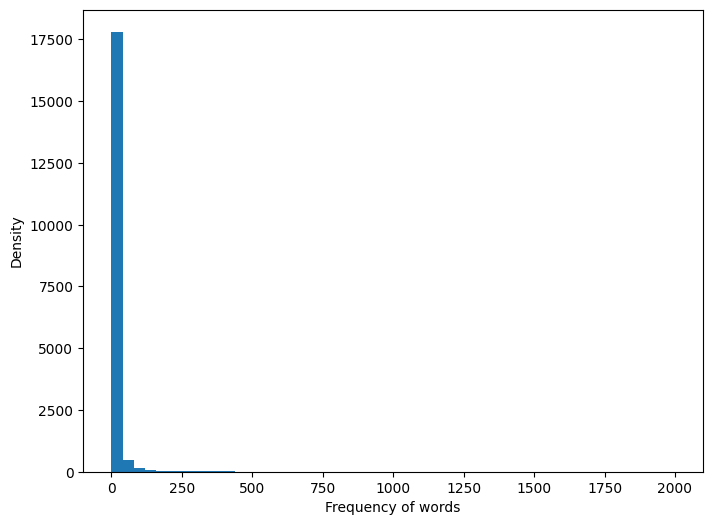

In [231]:
features_counts = np.sum(train_ds_features.toarray(),axis=0)
features_counts_df = pd.DataFrame(dict(features = features, counts = features_counts))
plt.figure(figsize=(8,6))
plt.hist(features_counts_df.counts, bins=50, range=(0,2000))
plt.xlabel("Frequency of words")
plt.ylabel('Density')

In [232]:
len(features_counts_df[features_counts_df.counts==1])

9704

In [234]:
count_vectorizer =  CountVectorizer(max_features=1000)
feature_vector = count_vectorizer.fit(corpus.Text)
features = feature_vector.get_feature_names()
train_ds_features = count_vectorizer.transform(corpus.Text)
features_counts =  np.sum(train_ds_features.toarray(),axis=0)
features_counts = pd.DataFrame(dict(features = features, counts = features_counts))
features_counts.sort_values('counts', ascending=False)[0:15]

c:\Users\oicaa4986\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,counts
752,recomand,5443
300,excelent,2197
111,bun,2049
581,multumit,1971
28,am,1812
127,calitate,1678
707,produs,1669
833,slab,1666
94,bateria,1554
408,incarca,1529


In [235]:
negative_df = corpus[corpus['Sentiment'] == 0]
positive_df = corpus[corpus['Sentiment'] == 1]

print(negative_df.head())
print(positive_df.head())

    Sentiment                                               Text
0           0    slab aspect frumoasa vrea joace tastatura poate
2           0  țeapa zile mari primul rand stica spune produc...
3           0  merita cumparate merita cumparate create limit...
6           0  produs excelent mort nu-l cumparati e produs e...
11          0  recomand cumparat incarcat tinut zile masina f...
   Sentiment                                               Text
1          1  multumit incarca repede tine incarcari complet...
4          1  recomand ceas excelent nevoie vreme nu-l compa...
5          1  bun pica geam e teapan lasa impresia calitate ...
7          1  recomand produs aproape jumatate an timp probl...
8          1                               e super luna pot sta


In [236]:
count_by_sentiment = corpus.groupby(['Sentiment']).size()
count_by_sentiment

Sentiment
0    6000
1    6000
dtype: int64

<AxesSubplot: >

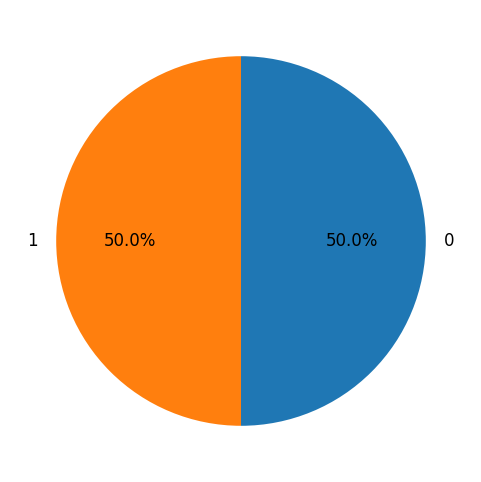

In [237]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
count_by_sentiment.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

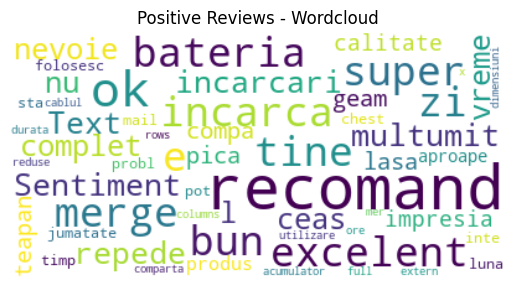

In [238]:
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(positive_df))
plt.figure()
plt.title("Positive Reviews - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

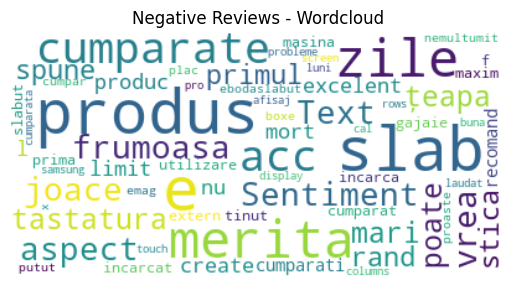

In [246]:
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(negative_df))
plt.figure()
plt.title("Negative Reviews - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()